In [1]:
!pip install deberta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.5 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 1.2 MB 10.7 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=22444714ba3881600fde4409d9af8bee537e5f5ec9be364ab0721af541ade519
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 82.0 MB/s 
     |████████████████████████████████| 596 kB 85.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from google.colab import drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/cs542/'

Mounted at /content/drive


In [5]:
import pandas as pd

**Load and process Train data**

In [6]:
df_train = pd.read_csv(filepath+'TrainProcessed.csv')

In [7]:
df_test = pd.read_csv(filepath+'TestProcessed.csv')

In [8]:
def replace_symbols(df_list):
  updated_list = []
  for each_list in df_list:
    temp = each_list.replace(',', '')
    temp = temp.replace('[','')
    temp = temp.replace(']','')
    temp = temp.replace("'",'')
    temp = temp.replace(' s ',' ')

    updated_list.append(temp)
  return updated_list

In [9]:
df_train_text = replace_symbols(df_train.Text_proc)
df_train_title = replace_symbols(df_train.Title_proc)

In [10]:
df_test_text = replace_symbols(df_test.Text_proc)
df_test_title = replace_symbols(df_test.Title_proc)

In [11]:
df_train_label = df_train.Label.eq('T').mul(1) ##Convert T to 1 and F to 0

In [12]:
df_test_label = df_test.Label.eq('T').mul(1) ##Convert T to 1 and F to 0

In [ ]:
# Get the lists of sentences and their labels.

In [13]:
rte_train_sentences = []
for i in range(len(df_train_text)):
  rte_train_sentences.append(df_train_text[i] + ' ' + df_train_title[i])

In [15]:
rte_train_labels = df_train_label

**Start training**

**Tokenizer**
We load the tokenizer using autotokenizer here but the same can be done using 'DebertaV2Tokenizer'. When you are using the second one, we need to install sentence pipe before installing transformers to avoid errors.

In [17]:
from transformers import AutoTokenizer
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
import torch
checkpoint = 'microsoft/mdeberta-v3-base'
#tokenizer_mdeberta = DebertaV2Tokenizer.from_pretrained(checkpoint) #can use either
tokenizer_mdeberta = AutoTokenizer.from_pretrained(checkpoint, do_lower_case=True)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


**Preprocessing**
Here we used the sentence max length as 80.

In [19]:
import torch
def process_trainingdata(tokenizer,training_set,train_labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  token_type_ids=[]

  # For every sentence...
  for sent1 in training_set:
    encoded_dict = tokenizer(
                        sent1,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 80,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  token_type_ids = torch.cat(token_type_ids, dim=0)
  labels = torch.tensor(train_labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', training_set[0])
  print('Token IDs:', input_ids[0])
  #print('Toke type ids:', token_type_ids[0])
  return input_ids,attention_masks,labels

In [20]:
input_ids_mdeberta,attention_masks_mdeberta,labels_mdeberta = process_trainingdata(tokenizer_mdeberta,rte_train_sentences,rte_train_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  back television station register foreign agent editor chief say confirm later day intelligence agency say report television station broadcast cable state run propaganda machine contribute campaign interfere year presidential election favor candidate report insist comply registration requirement act require disclose financial information repeatedly deny allegation election meddling say view action unfriendly act editor chief say comply demand order avoid legal action government criminal case registration choose congratulate american freedom speech believe say confirm receive registration operate studio hire pay employee produce english language programming right know act influence government public behalf foreign principal say act announce long allow advertisement back news organization cite intelligence television station participate effort influence election require foreign government political party lobbyist public relation firm hire register pass lead effort combat german

In [21]:
from torch.utils.data import TensorDataset, random_split

def datasetsize(input_ids, attention_masks, labels):
  dataset = TensorDataset(input_ids, attention_masks, labels)

  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size)) 
  return train_dataset,val_dataset

In [22]:
train_dataset_mdeberta,val_dataset_mdeberta = datasetsize(input_ids_mdeberta,attention_masks_mdeberta,labels_mdeberta)

36,368 training samples
4,041 validation samples


In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
def dataloader(size,train_dataset,val_dataset):
  batch_size = size
 
  train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
            drop_last=True
        )
  validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            drop_last=True
        )
  return train_dataloader, validation_dataloader

In [24]:
train_dataloader_mdeberta, validation_dataloader_mdeberta = dataloader(32,train_dataset_mdeberta,val_dataset_mdeberta)

In [25]:
print(len(train_dataloader_mdeberta.dataset))

36368


** Used to load data if model fails during checkpoints**

In [ ]:
##save data loader for checkpoint
torch.save(train_dataloader_mdeberta, filepath+'train_dataloader_mdeberta.pt')
torch.save(validation_dataloader_mdeberta, filepath+'validation_dataloader_mdeberta.pt')

** Added to be able to print detailed error message when using cuda**

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

**The training is done on 2 labels**

In [27]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_mdeberta = AutoModelForSequenceClassification.from_pretrained(
#model_mdeberta = DebertaV2ForSequenceClassification.from_pretrained(
    "microsoft/mdeberta-v3-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # need to change to the number of label in test for zero-shot performance
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.

)

# Tell pytorch to run this model on the GPU.
model_mdeberta.cuda()

Downloading:   0%|          | 0.00/534M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [28]:
def optimizer(model):
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  return optimizer

In [29]:
optimizer_mdeberta = optimizer(model_mdeberta)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [30]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
def scheduler(train_dataloader,optimizer):
  epochs = 4

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs
  #print(train_dataloader.size())

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps) 
  return scheduler

In [31]:
scheduler_mdeberta = scheduler(train_dataloader_mdeberta,optimizer_mdeberta)

In [32]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [33]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
import random
import numpy as np

def modeltraining(model,train_dataloader,validation_dataloader,optimizer,scheduler):

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  total_t0 = time.time()
  epochs = 4

  #with torch.no_grad():
  for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    model.train()
    #print('reached here')

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #print(b_input_ids.size(),b_labels.size())

        model.zero_grad()        
        #print('reached 1')
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    torch.save(model,'/content/drive/MyDrive/cs542/mdberta_models'+str(epoch_i)+'.pt')
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, training_stats

In [38]:
model_mdeberta, training_stats = modeltraining(model_mdeberta,train_dataloader_mdeberta,validation_dataloader_mdeberta,optimizer_mdeberta,scheduler_mdeberta)


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  1,136.    Elapsed: 0:00:38.
  Batch   200  of  1,136.    Elapsed: 0:01:17.
  Batch   300  of  1,136.    Elapsed: 0:01:55.
  Batch   400  of  1,136.    Elapsed: 0:02:34.
  Batch   500  of  1,136.    Elapsed: 0:03:12.
  Batch   600  of  1,136.    Elapsed: 0:03:50.
  Batch   700  of  1,136.    Elapsed: 0:04:29.
  Batch   800  of  1,136.    Elapsed: 0:05:07.
  Batch   900  of  1,136.    Elapsed: 0:05:45.
  Batch 1,000  of  1,136.    Elapsed: 0:06:24.
  Batch 1,100  of  1,136.    Elapsed: 0:07:02.

  Average training loss: 0.05
  Training epcoh took: 0:07:20

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.13
  Validation took: 0:00:14

======== Epoch 2 / 4 ========
Training...
  Batch   100  of  1,136.    Elapsed: 0:00:38.
  Batch   200  of  1,136.    Elapsed: 0:01:17.
  Batch   300  of  1,136.    Elapsed: 0:01:55.
  Batch   400  of  1,136.    Elapsed: 0:02:33.
  Batch   500  of  1,136.    Elapsed: 0:03:12.
  Batch  

In [ ]:
#torch.save(model_mdeberta,filepath+'model_mdeberta_eng_final_retrained.pt')

In [39]:
#Clear CUDA cache
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
#retrained again for 2 epochs
#model_mdeberta_eng = torch.load(filepath+'model_mdeberta_eng_final.pt')

In [40]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.05,0.13,0.98,0:07:20,0:00:14
2,0.04,0.12,0.97,0:07:19,0:00:14
3,0.02,0.13,0.98,0:07:19,0:00:14
4,0.01,0.13,0.98,0:07:19,0:00:14


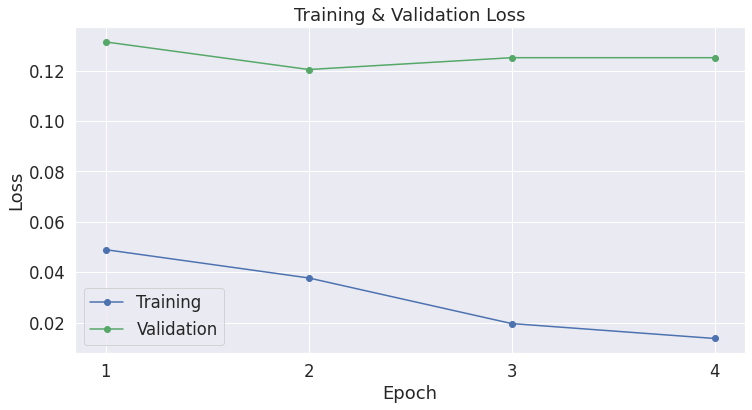

In [41]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

**Prediction**

In [43]:
rte_test_sentences = []
for i in range(len(df_test_text)):
  rte_test_sentences.append(df_test_text[i] + ' ' + df_test_title[i])

In [44]:
rte_test_labels = df_test_label

In [45]:
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def test_preprocessing(test_sentences,test_labels, tokenizer, batchsize,maxlength):
  input_ids_test,attention_masks_test,labels_test = process_trainingdata(tokenizer,test_sentences,test_labels)

  # Set the batch size.  
  batch_size = batchsize 

  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  return prediction_dataloader

In [46]:
prediction_dataloader_eng_test = test_preprocessing(rte_test_sentences,rte_test_labels,tokenizer_mdeberta,32,80)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  lobbyist lead business huddle spring state map campaign enact statewide lgbt anti discrimination law record number republican lawmaker throw support propose protection lesbian gay bisexual transgender people hundred company back cause bill far fall short time run legislative session lead backer hearten progress determine retool year definitely need ramp grassroot say lobbyist group state business support lgbt protection lot agree policy worried effect home year transgender bathroom access erupt culture war flashpoint conservative statehouse activist momentum building affirmative legislation nation populous state offer breakthrough national movement advance lgbt civil right protection view advocate stepping stone ultimate goal federal anti discrimination law state concentrate law fully guard people fire job kick housing deny service restaurant hotel business fight continue ruling legalize sex marriage nationally strategy year making aim build bipartisan support economic argum

In [47]:
def predicttestset(model,prediction_dataloader):
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []
  total_eval_accuracy = 0
  act_pred_label = []
  act_true_labels = []

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_eval_accuracy += flat_accuracy(logits, label_ids)
  
    # Store predictions and true labels
    predictions.append(logits)
    #print(type(logits))
    true_labels.append(label_ids)
    predict_content = logits.argmax(axis=-1).flatten().tolist()
    act_pred_label += predict_content
    #print(act_pred_label)
    act_true_labels += label_ids.flatten().tolist()
    #print(act_pred_label)
  #print(len(act_pred_label),len(act_true_labels))
  return total_eval_accuracy*100/len(prediction_dataloader), act_pred_label,act_true_labels

In [49]:
import torch

model_loaded = torch.load('/content/drive/MyDrive/cs542/mdberta_models1.pt') ##choose based on which epoch

In [50]:
acc_ee, pred_label_ee, true_labels_ee = predicttestset(model_loaded,prediction_dataloader_eng_test)

In [55]:
acc_ee

97.56205673758865

In [51]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [53]:
precision = precision_score(pred_label_ee, true_labels_ee)
print('Precision: %f' % precision)

Precision: 0.990659


In [54]:
f1 = f1_score(pred_label_ee, true_labels_ee)
print('F1 score: %f' % f1)

F1 score: 0.974724
